#  Predicting the closing price stock price of APPLE inc:

### What is ARIMA?
Autoregressive Integrated Moving Average (ARIMA) Model converts non-stationary data to stationary data before working on it. It is one of the most popular models to predict linear time series data.


ARIMA model has been used extensively in the field of finance and economics as it is known to be robust, efficient and has a strong potential for short-term share market prediction.

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error


# For time stamps
from datetime import datetime

In [7]:
# Get the stock quote
df = DataReader('AAPL', data_source='yahoo', start='2012-01-01', end=datetime.now())
# Show teh data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.557464
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.624951
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.765113
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.898556
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.878098
...,...,...,...,...,...,...
2022-06-17,133.080002,129.809998,130.070007,131.559998,134118500.0,131.559998
2022-06-21,137.059998,133.320007,133.419998,135.869995,81000500.0,135.869995
2022-06-22,137.759995,133.910004,134.789993,135.350006,73409200.0,135.350006


Visualize the per day closing price of the stock.

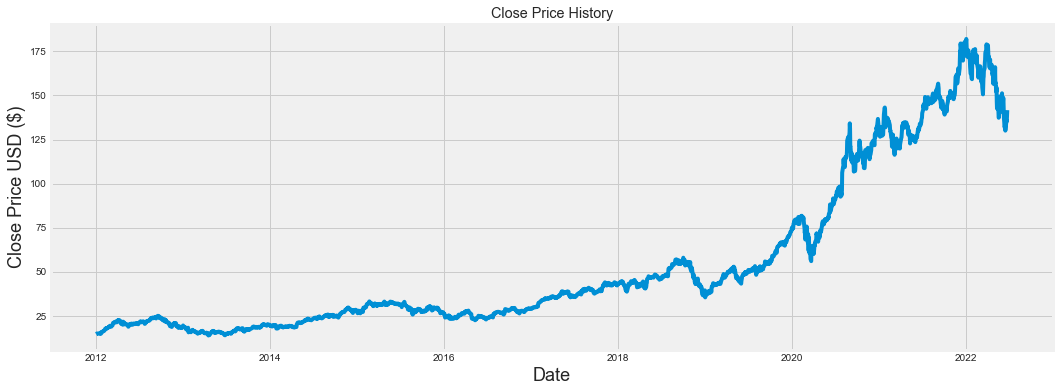

In [8]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

We can also visualize the data in our series through a probability distribution too

<AxesSubplot:ylabel='Density'>

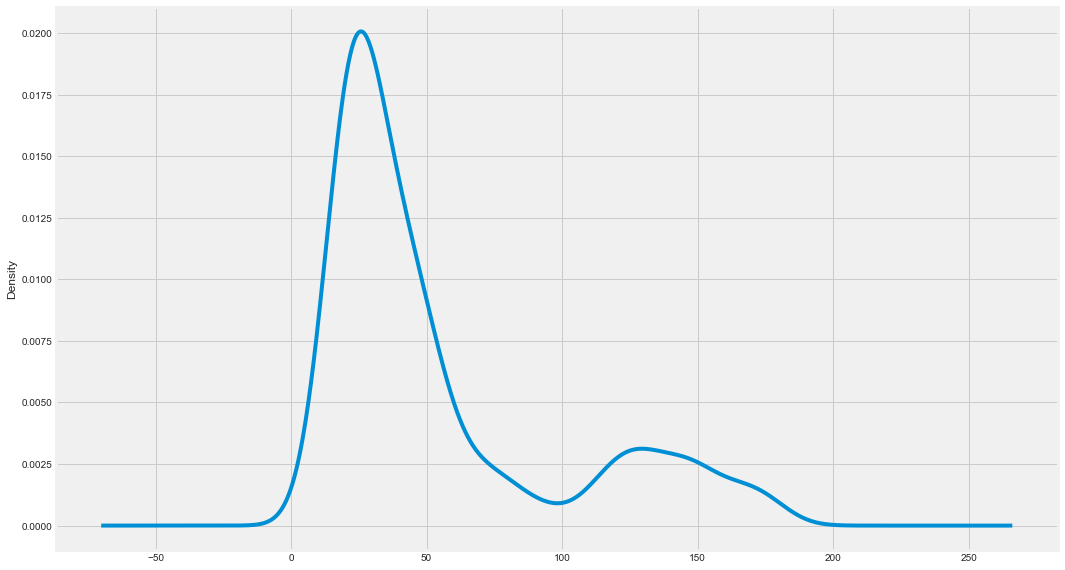

In [10]:
df['Close'].plot(figsize=(16,10),kind='kde')

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

1. **Level**: The average value in the series.

2. **Trend**: The increasing or decreasing value in the series.

3. **Seasonality**: The repeating short-term cycle in the series.

4. **Noise**: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.


**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:


**Null Hypothesis**: The series has a unit root (value of a =1)


**Alternate Hypothesis**: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.


If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.


**So let's check for stationarity:

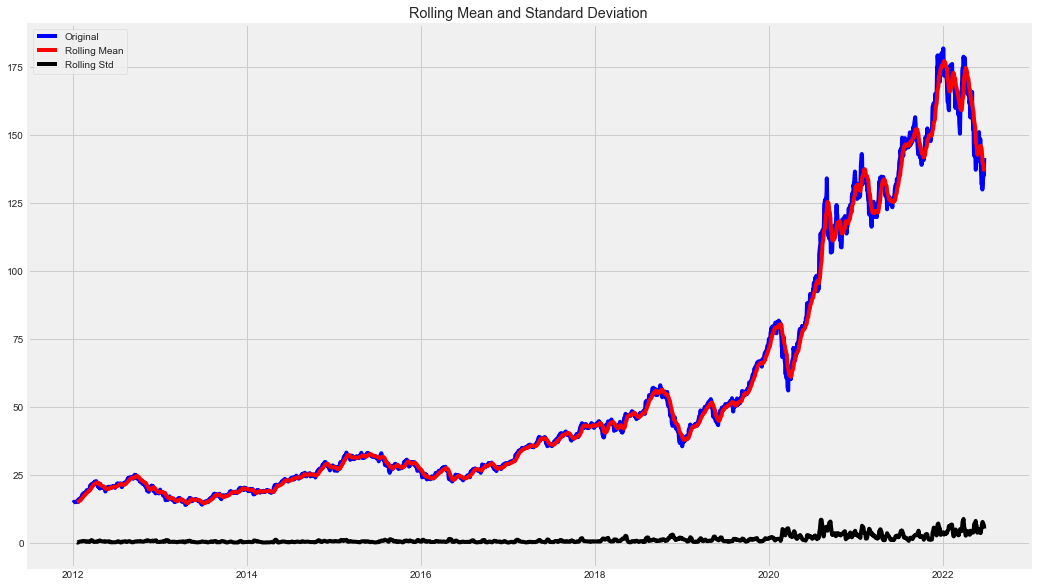

Results of dickey fuller test
Test Statistics                   0.366377
p-value                           0.980193
No. of lags used                 28.000000
Number of observations used    2608.000000
critical value (1%)              -3.432860
critical value (5%)              -2.862649
critical value (10%)             -2.567360
dtype: float64


In [13]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(16,10))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.


In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.


So let us separate Trend and Seasonality from the time series.



<Figure size 432x288 with 0 Axes>

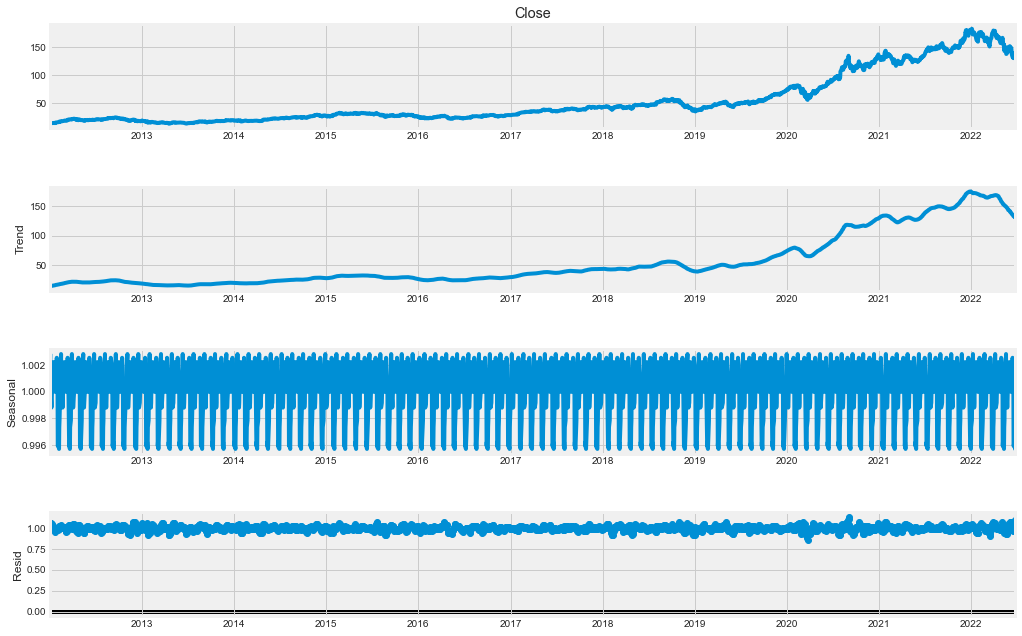

In [20]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df['Close'], model='multiplicative', extrapolate_trend='freq', period=30) 
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 10)

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No handles with labels found to put in legend.


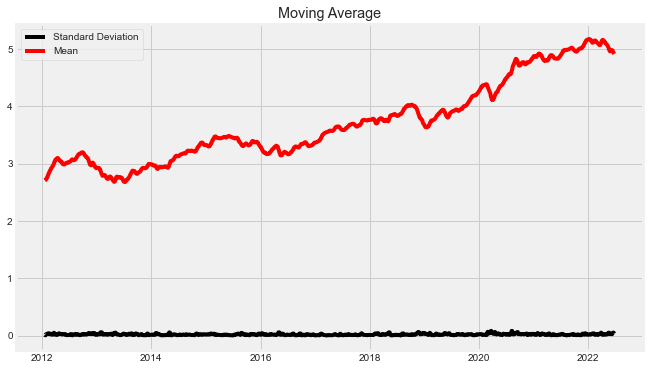

In [21]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

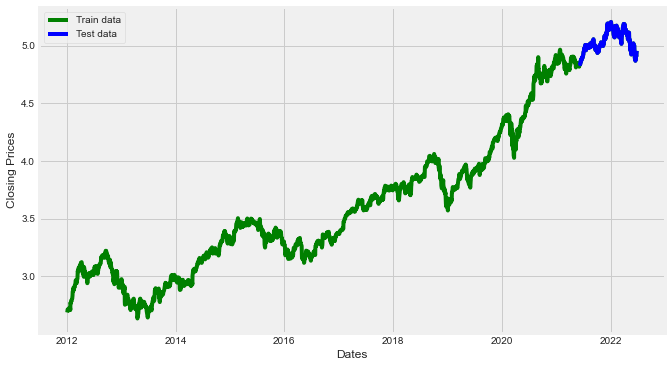

In [22]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Its time to choose parameters p,q,d for ARIMA model.we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

#### Auto ARIMA: Automatically discover the optimal order for an ARIMA model.


The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, **forecast::auto.arima**.


The **auro_arima** function works by conducting differencing tests (i.e., **Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron**) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the **Canova-Hansen** to determine the optimal order of seasonal differencing, D.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12273.749, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12282.117, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12282.042, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12269.938, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12280.132, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12280.146, Time=0.97 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-12278.125, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-12277.502, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.056 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2370
Model:               SARIMAX(1, 1, 0)   Log Likelihood                6144.059
Date:                Mon, 27 Jun 2022   AIC                         -12282.117
Time:               

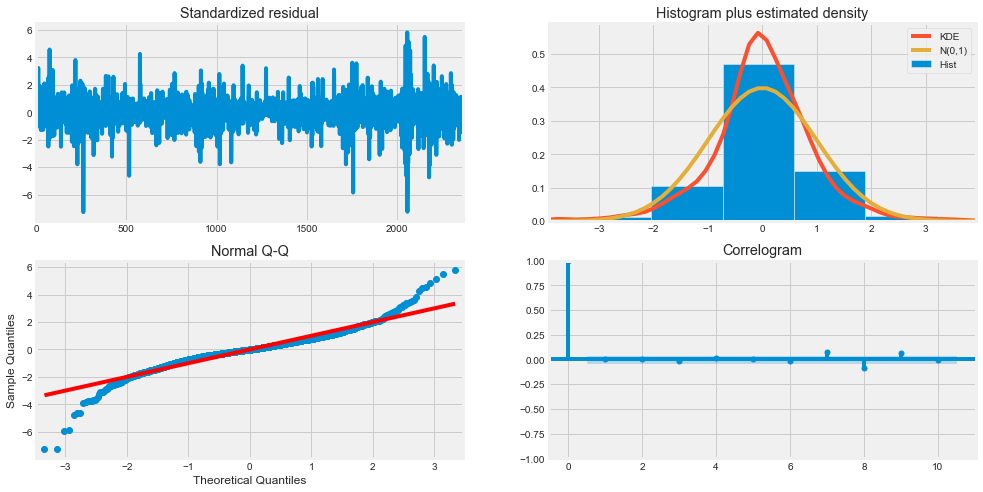

In [23]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

So how to interpret the plot diagnostics?


**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.


**Top Right**: The density plot suggest normal distribution with mean zero.


**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.


Overall, it seems to be a good fit. Let’s start forecasting the stock prices.


Next, create an ARIMA model with provided optimal parameters p, d and q.

**So the Auto ARIMA model provided the value of p,d, and q as 1, 1 and 0 respectively.**

In [28]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2370
Model:                 ARIMA(1, 1, 0)   Log Likelihood                6140.751
Date:                Mon, 27 Jun 2022   AIC                         -12277.502
Time:                        12:40:23   BIC                         -12265.962
Sample:                             0   HQIC                        -12273.301
                               - 2370                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0635      0.013     -4.934      0.000      -0.089      -0.038
sigma2         0.0003   4.93e-06     66.511      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

c:\Users\Chara\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Chara\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Chara\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

In [29]:
fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf

c:\Users\Chara\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: too many values to unpack (expected 3)